In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, CombinedSpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram, AudioToMelSpectrogram, AudioToMFCCSpectrogram
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-15 13:33:53,480	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.lograndint(32, 128),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    # "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003),
    "nmels" : tune.randint(64, 256),
    "nmfcc" : tune.randint(32, 128)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [4]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.choice([0.0001]),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.choice([128]),
    "nfft" : tune.choice([4096]),
    # "scale" : tune.uniform(0.5, 4),
    "power" : tune.choice([2]),
    "patience" : tune.choice([5]),
    "EarlyDelta" : tune.choice([0.1]),
    "epochs" : tune.choice([15]),
    "l1" : tune.choice([0.001]),
    "l2" : tune.choice([0.0015]),
    "nmels" : tune.choice([128]),
    "nmfcc" : tune.choice([64])
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [4]:
def getSamples(split : list, sizes : list = [None, None, None]):
    """
        Computes the indices for the datasets used in the dataloader. Intended to be used after the splitDataset method.

        Inputs:
            split : list - list containing indices of the train, test and val splits
            sizes : list - list containing the number of samples. Uses absolute samples when given an int, percentage for float <= 1 and all sample for None type

        Outputs: 
            samples : list - list containing the split indices
    """
    samples = []
    for idx, data in enumerate(split):
        data_indices = []
        if type(sizes[idx]) is int:
            data_indices = split[idx][:sizes[idx]]
        elif (type(sizes[idx]) is float and sizes[idx] <= 1.0):
            indices = round(len(split[idx])*sizes[idx])
            data_indices = split[idx][:indices]
        elif sizes[idx] is None:
            data_indices = split[idx]
        
        samples.append(data_indices)
        
    return samples

In [5]:
import importlib
import sys

In [12]:
_ = importlib.reload(sys.modules["functions"])
_ = importlib.reload(sys.modules["functions.dl.data_classes"])
from functions.dl.data_classes import CombinedSpectroDataset

In [23]:
# File locations for the label files
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"

# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.001
test_sample_size = 0.01
val_sample_size = 0.0001

# Load  dataset

# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)
ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True, cut = True, sample = (False,60))

# Get samples and split the dataset
split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])

In [34]:
config["batch_size"]=16

In [9]:
# Load data
train_dataloader, val_dataloader = load_data(config, ds, split = split, clip_length=60)

In [10]:
batch = next(iter(train_dataloader))

Getting index 183937, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27909117_audio_dn.pt
Getting index 111451, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23064290_audio_dn.pt
Getting index 166681, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_513278_audio_dn.pt
Getting index 107428, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22794256_audio_dn.pt
Getting index 187518, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22329480_audio_dn.pt
Getting index 84886, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_133420_audio_dn.pt
Getting index 175688, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_25815652_audio_dn.pt
Getting index 141318, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_55409_audio_dn.pt
Getting index 194117, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27645228_audio_dn.pt
Getting index 68248, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27947151_audio_dn.pt
Getting index 118225, F:\Persönlic

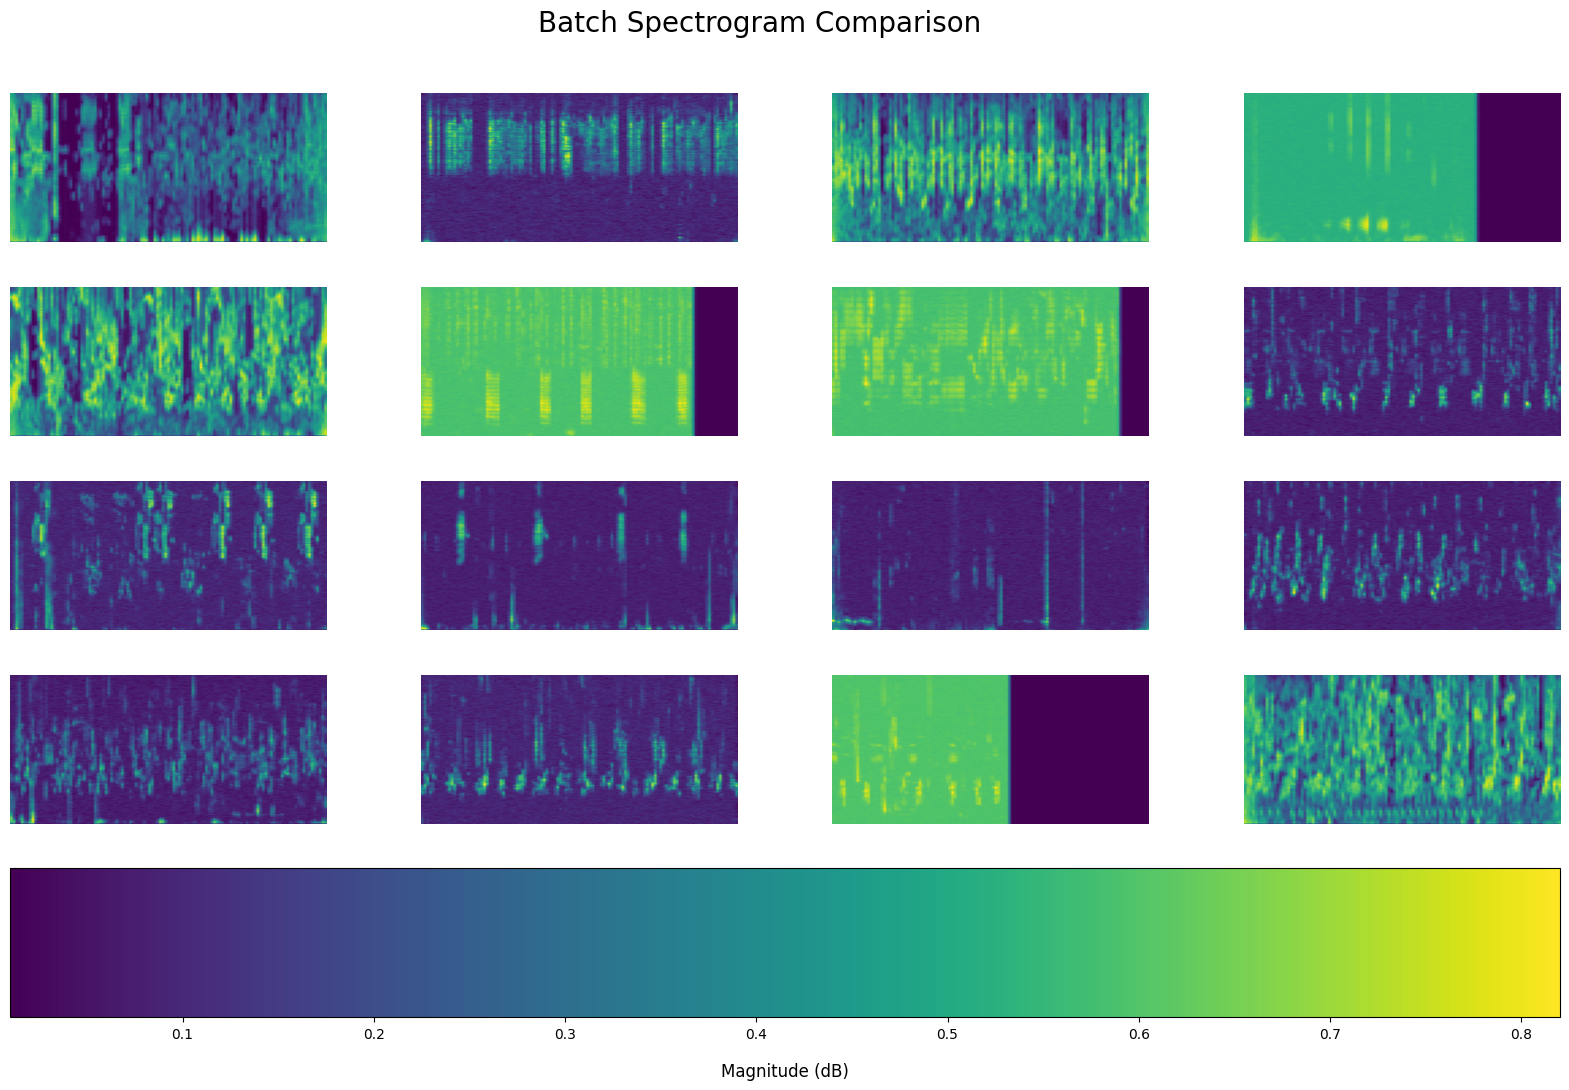

In [10]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 12))
    
# 3 rows, 7 columns
# Column index 3 is the "divider" for the colorbar
gs = gridspec.GridSpec(5, 4, figure=fig, 
                        width_ratios=[1, 1, 1, 1],
                        wspace=0.3, hspace=0.3)

fig.suptitle('Batch Spectrogram Comparison', fontsize=20, y=0.95)

atls = AudioToLogSpectrogram().to("cuda")

for i in range(batch[0].shape[0]):
    
    wav = batch[0][i]

    img_tensor = atls(wav).squeeze(0).squeeze(0)
    img = img_tensor.detach().cpu().numpy()

    row = i // 4
    col = i % 4

    ax_l = fig.add_subplot(gs[row, col])
    im = ax_l.imshow(img, aspect='auto', origin='lower', cmap='viridis')
    ax_l.axis('off')

# Set colorbar to middle of the plot
cbar_ax = fig.add_subplot(gs[4, :])
cbar = fig.colorbar(im, orientation='horizontal', cax=cbar_ax)

# Set the label below colorbar
cbar.ax.set_xlabel('Magnitude (dB)', fontsize=12, labelpad=15)

plt.show()

In [20]:
# Rayt[tune] parameters
concurrent_trials = 2

# File locations for the label files
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"

# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.001
test_sample_size = 0.001
val_sample_size = 0.0001

# Load  dataset

# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)
ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True, cut = False, sample = (False,60))

# Get samples and split the dataset
split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])


trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds, spectro_mode = "atls", split = [train_indices, val_indices], clip_length=60 #train_size = int(np.floor(0.7 * len(ds))), val_size = int(np.floor(0.1 * len(ds)))# train_size=500, val_size=100
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

# Currently unused
hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

AttributeError: 'NoneType' object has no attribute 'group'

In [11]:
model, df = getBestModel(return_df=True)

2026-01-12 17:15:57,320	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}


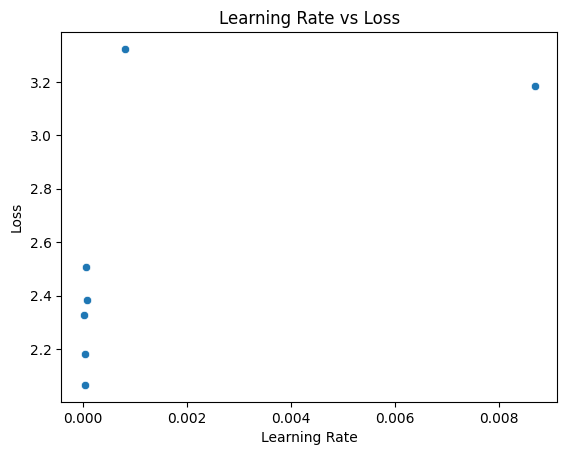

In [12]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

In [35]:
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])

In [44]:
best_model_df = df[df["accuracy"] ==  df.sort_values("accuracy", ascending=False).iloc[0].accuracy]
if best_model_df.shape[0] > 1:
    best_model_df.sort_values("loss", ascending=True, inplace=True)
    
test_dataloader = SpectroDataLoader(ds, int(best_model_df.iloc[0]["config/batch_size"]), samples = test_indices, sample_rate = 16000, clip_length = 60, device = "cuda")

C:\Users\mfher\AppData\Local\Temp\ipykernel_29188\3548463851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_df.sort_values("loss", ascending=True, inplace=True)


Getting index 40310, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28301701_audio_dn.pt
Getting index 40331, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_168847_audio_dn.pt
Getting index 40376, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22822545_audio_dn.pt
Getting index 40387, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_156303_audio_dn.pt
Getting index 40343, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23291133_audio_dn.pt
Getting index 40412, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27625273_audio_dn.pt
Getting index 40223, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27828511_audio_dn.pt
Getting index 40322, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22675816_audio_dn.pt
Getting index 40269, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22762862_audio_dn.pt
Getting index 40253, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27464032_audio_dn.pt
Getting index 40338, F:\Persönliches\Gi

2026-01-12 17:21:25,037	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40235, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27328480_audio_dn.pt
Getting index 40373, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27911131_audio_dn.pt
Getting index 40409, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28436649_audio_dn.pt
Getting index 40359, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27478700_audio_dn.pt
Getting index 40348, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\19466355_audio_dn.pt
Getting index 40212, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27730363_audio_dn.pt
Getting index 40340, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22470992_audio_dn.pt
Getting index 40249, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27586868_a

2026-01-12 17:21:31,304	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40380, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23198437_audio_dn.pt
Getting index 40220, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22880237_audio_dn.pt
Getting index 40296, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_76101_audio_dn.pt
Getting index 40266, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_530627_audio_dn.pt
Getting index 40344, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_26621727_audio_dn.pt
Getting index 40290, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_832225_audio_dn.pt
Getting index 40408, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_976416_audio_dn.pt
Getting index 40291, F:\Persönliches\Git\BioOTon\augmented_data_denois

2026-01-12 17:21:32,910	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40360, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22943865_audio_dn.pt
Getting index 40379, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22331413_audio_dn.pt
Getting index 40314, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_541874_audio_dn.pt
Getting index 40377, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27397567_audio_dn.pt
Getting index 40215, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27773509_audio_dn.pt
Getting index 40363, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\26512400_audio_dn.pt
Getting index 40270, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_122710_audio_dn.pt
Getting index 40280, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn

2026-01-12 17:21:34,668	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Getting index 40328, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27488816_audio_dn.pt
Getting index 40265, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23042192_audio_dn.pt
Getting index 40411, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27754170_audio_dn.pt
Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40336, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_373407_audio_dn.pt
Getting index 40325, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\23490441_audio_dn.pt
Getting index 40221, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27454166_audio_dn.pt
Getting index 40317, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27464014_audio_dn.pt
Getting index 40341, F:\Persönliches\Git\BioOTon\augmented_data_denoised\

2026-01-12 17:21:36,499	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40309, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28602927_audio_dn.pt
Getting index 40281, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28142865_audio_dn.pt
Getting index 40386, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_805125_audio_dn.pt
Getting index 40257, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_19626852_audio_dn.pt
Getting index 40260, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27322432_audio_dn.pt
Getting index 40300, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22707070_audio_dn.pt
Getting index 40252, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_624857_audio_dn.pt
Getting index 40315, F:\Persönliches\Git\BioOTon\augmented_data_d

2026-01-12 17:21:38,057	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40358, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22665953_audio_dn.pt
Getting index 40230, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_193860_audio_dn.pt
Getting index 40248, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_313176_audio_dn.pt
Getting index 40293, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22733198_audio_dn.pt
Getting index 40240, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27383106_audio_dn.pt
Getting index 40289, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_981994_audio_dn.pt
Getting index 40305, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_527291_audio_dn.pt
Getting index 40224, F:\Persönliches\Git\BioOTon\AudioTensors_denoise

2026-01-12 17:21:39,573	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40347, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28233087_audio_dn.pt
Getting index 40321, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_563251_audio_dn.pt
Getting index 40390, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22932682_audio_dn.pt
Getting index 40213, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22707070_audio_dn.pt
Getting index 40392, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\23202378_audio_dn.pt
Getting index 40403, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_297382_audio_dn.pt
Getting index 40246, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27790273_audio_dn.pt
Getting index 40326, F:\Persönliches\Git\BioOTon\AudioTensors_denoised

2026-01-12 17:21:41,239	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Getting index 40231, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\23052727_audio_dn.pt
Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40352, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_802564_audio_dn.pt
Getting index 40285, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_165198_audio_dn.pt
Getting index 40391, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23559300_audio_dn.pt
Getting index 40250, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_541469_audio_dn.pt
Getting index 40264, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23048462_audio_dn.pt
Getting index 40405, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27845154_audio_dn.pt
Getting index 40361, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\2

2026-01-12 17:21:42,537	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40307, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27892974_audio_dn.pt
Getting index 40410, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27280612_audio_dn.pt
Getting index 40320, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23230972_audio_dn.pt
Getting index 40306, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28054609_audio_dn.pt
Getting index 40345, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\26797663_audio_dn.pt
Getting index 40355, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\23217479_audio_dn.pt
Getting index 40272, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_955305_audio_dn.pt
Getting index 40276, F:\Persönliches\Git\BioOTon\augmented_data_denoised\

2026-01-12 17:21:44,195	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40378, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27917203_audio_dn.pt
Getting index 40236, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27441385_audio_dn.pt
Getting index 40256, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27645212_audio_dn.pt
Getting index 40277, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27804491_audio_dn.pt
Getting index 40372, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22744522_audio_dn.pt
Getting index 40342, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_651961_audio_dn.pt
Getting index 40303, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_926763_audio_dn.pt
Getting index 40354, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn

2026-01-12 17:21:45,998	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40327, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_189455_audio_dn.pt
Getting index 40399, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27973741_audio_dn.pt
Getting index 40302, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27881147_audio_dn.pt
Getting index 40261, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27905583_audio_dn.pt
Getting index 40268, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27434860_audio_dn.pt
Getting index 40369, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27576048_audio_dn.pt
Getting index 40382, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\23247467_audio_dn.pt
Getting index 40330, F:\Persönliches\Git\BioOTon\augmented_data_denoised\

2026-01-12 17:21:47,648	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}
Getting index 40402, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27730617_audio_dn.pt
Getting index 40350, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28489787_audio_dn.pt
Getting index 40312, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27943673_audio_dn.pt
Getting index 40273, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22642519_audio_dn.pt
Getting index 40365, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_416954_audio_dn.pt
Getting index 40323, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22250030_audio_dn.pt
Getting index 40219, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_112770_audio_dn.pt
Getting index 40395, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn

2026-01-12 17:21:48,745	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_a20aba1f: FileNotFoundError('Could not fetch metrics for train_model_a20aba1f: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_a20aba')


Best Hyperparameters: {'lr': 3.653057830560235e-05, 'batch_size': 16, 'nfft': 512, 'power': 1.6008862144288007, 'patience': 7, 'EarlyDelta': 0.09624172029593457, 'epochs': 22, 'l1': 0.002752823738855979, 'l2': 0.0011626299567182715, 'nmels': 190, 'nmfcc': 70}


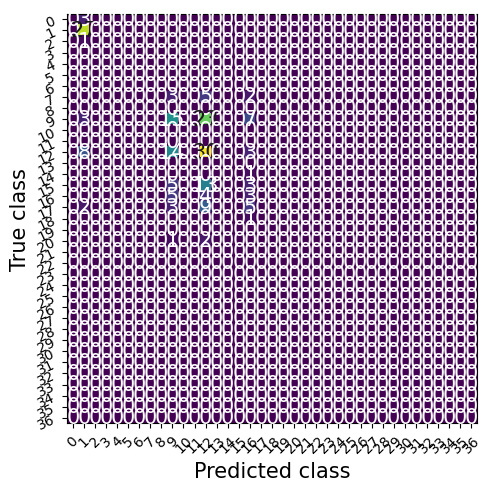

Recall of the custom cnn: tensor(0.1757, device='cuda:0')
F1-score of the custom cnn: tensor(0.1390, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.1757, device='cuda:0')


In [43]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel().to(device)
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0).to(device)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())